In [132]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import numpy

In [3]:
raw_data_files = os.listdir("../ingestion_service/data/raw_data")
csv_files = [f for f in raw_data_files if re.search(r'.*\.csv$', f)]
csv_files

['esg_raw_data_on_corporations_myu_2.csv',
 'esg_raw_data_on_corporations_myu_3.csv',
 'esg_raw_data_on_corporations_7.csv',
 'esg_raw_data_on_corporations_6.csv',
 'esg_raw_data_on_corporations_myu_4.csv',
 'esg_raw_data_on_corporations_myu_5.csv',
 'esg_raw_data_on_corporations_1.csv']

In [5]:
dfs = []
number_of_rows = 0
for csv in csv_files:
    print(f"Reading {csv}")
    df_chunk = pd.read_csv(f"../ingestion_service/data/raw_data/{csv}", sep='|')
    print(df_chunk.shape)
    number_of_rows += df_chunk.shape[0]
    # Optional preprocessing here
    # df_chunk = df_chunk[['column1', 'column2']]  # example
    
    dfs.append(df_chunk)

print("total number of rows in raw data: ", number_of_rows)
df = pd.concat(dfs, ignore_index=True)

Reading esg_raw_data_on_corporations_myu_2.csv
(1322420, 15)
Reading esg_raw_data_on_corporations_myu_3.csv
(1024697, 15)
Reading esg_raw_data_on_corporations_7.csv
(86371, 15)
Reading esg_raw_data_on_corporations_6.csv
(257603, 15)
Reading esg_raw_data_on_corporations_myu_4.csv
(812742, 15)
Reading esg_raw_data_on_corporations_myu_5.csv
(522838, 15)
Reading esg_raw_data_on_corporations_1.csv
(2764252, 15)
total number of rows in raw data:  6790923


In [6]:
def add_industry_matching(esg_df):
    try:
        companies_df = pd.read_csv('../ingestion_service/data/industry.csv')

        companies_df = companies_df.rename(columns={'Industry': 'industry_name'})
        companies_df.drop(columns=['Company Name'], inplace=True)

        res_df = pd.merge(esg_df, companies_df, how="left", on=['perm_id'])
        return res_df
        
    except Exception as e:
        raise Exception(f'Exception while running industry matching {e}')

In [7]:
df = add_industry_matching(df)

In [8]:
df.head()

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name
0,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,int,REPORTED,Does the company have a formal grievance repor...,GRIEVANCE_REPORTING_PROCESS,Yes/No,0.00,2022-12-31,331,NaN,Clarity AI,2022-12-31 00:00:00,S,Saudi Arabia,Chemicals
1,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,int,CALCULATED,Does the company have appropriate communicatio...,IMPROVEMENT_TOOLS_BUSINESS_ETHICS,Yes/No,0.00,2019-12-31,331,NaN,Clarity AI,2019-09-27 14:29:37,S,Saudi Arabia,Chemicals
2,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,float,ESTIMATED,External cost of indirect emissions of polluta...,AIRPOLLUTANTS_INDIRECT,USD (000),193067.06,2021-12-31,331,NaN,Clarity AI,NaN,E,Saudi Arabia,Chemicals
3,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,int,REPORTED,Does the company have appropriate communicatio...,IMPROVEMENT_TOOLS_BUSINESS_ETHICS,Yes/No,0.00,2024-12-31,331,NaN,Clarity AI,2024-12-31 00:00:00,S,Saudi Arabia,Chemicals
4,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,float,REPORTED,The average overall attendance percentage of b...,BOARDMEETINGATTENDANCEAVG,%,100.00,2022-12-31,331,NaN,Clarity AI,2022-12-31 00:00:00,G,Saudi Arabia,Chemicals


In [9]:
len(df)

6790923

# Data Analysis

## Dataset summary - Overall and Missing Data

In [15]:
# there is no duplicate records in dataset
duplicates = df[df.duplicated()]
duplicates

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name


In [21]:
# number of rows by pillar and number of distinct metrics in each pillars
esg_count = df.groupby('pillar').size()
esg_count

pillars_metrics_count = df.groupby('pillar')['metric_name'].nunique()
pillars_metrics_count

pillar
E    4194801
G    1362829
S    1233293
dtype: int64

pillar
E    45
G    28
S    31
Name: metric_name, dtype: int64

<Figure size 600x600 with 0 Axes>

([<matplotlib.patches.Wedge at 0x127cfc890>,
 [Text(-1.025644513862269, -0.3975592172044688, 'E'),
  Text(1.0779081783042497, -0.21934894379689648, 'G'),
  Text(0.5940966588540602, 0.9257694961157678, 'S')],
 [Text(-0.5594424621066921, -0.21685048211152844, '61.8%'),
  Text(0.5879499154386816, -0.11964487843467078, '20.1%'),
  Text(0.3240527230113055, 0.5049651796995096, '18.2%')])

Text(0.5, 1.0, 'Pillar Distribution')

(-1.0999991081762783,
 1.0999946563577396,
 -1.0999983286639625,
 1.0999999204125697)

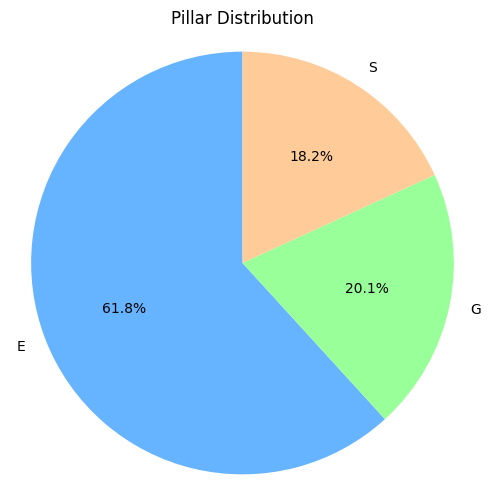

In [23]:
# Plot pie chart from esg_count
plt.figure(figsize=(6, 6))

plt.pie(
    esg_count.values,         # Sizes
    labels=esg_count.index,   # Labels
    autopct='%1.1f%%',        # Show percentage on slices
    startangle=90,            # Rotate chart
    colors=['#66b3ff', '#99ff99', '#ffcc99']  # Optional custom colors
)

plt.title('Pillar Distribution')
plt.axis('equal')  # Equal aspect ratio ensures a circle
plt.show()

In [25]:
providers = df.groupby('provider_name').size()
providers

provider_name
Clarity AI    6740769
Equilar         50154
dtype: int64

In [29]:
rows_of_each_company = (df.groupby(['perm_id', 'nb_points_of_observations'])
                            .size()
                            .reset_index(name='Count')
                            .sort_values(by='Count', ascending=False)
                       )
rows_of_each_company
# number of rows of each company does not match the nb_points_of_observations
# we can ignore nb_points_of_observations

,perm_id,nb_points_of_observations,Count
17307,4295889563,471,453
17235,4295889303,461,448
24256,4295912126,476,441
8762,4295874173,448,437
1815,4295860269,437,436
...,...,...,...
56917,5055420031,1,1
56774,5054562074,1,1
56613,5053129374,1,1
56588,5053083939,1,1


In [31]:
filtered_rows = rows_of_each_company[rows_of_each_company['Count'] <= 10]
filtered_rows

,perm_id,nb_points_of_observations,Count
35726,4298015141,19,10
17253,4295889406,22,10
64985,5084923771,10,10
55525,5051175389,10,10
16861,4295888045,21,10
...,...,...,...
56917,5055420031,1,1
56774,5054562074,1,1
56613,5053129374,1,1
56588,5053083939,1,1


In [33]:
total_count = filtered_rows['Count'].sum()
total_count

16251

In [28]:
# Companies missing industry name
# this one is before match
"""
no_industry_companies = df[df['industry_name'].isnull()]

number_of_companies_without_industy = no_industry_companies['perm_id'].nunique()
print(f"Total number of companies without industry: {number_of_companies_without_industy}")
print(f"number of rows: {len(no_industry_companies)}")
"""

Total number of companies without industry: 326
number of rows: 15480


In [39]:
no_industry_companies_list = no_industry_companies[['company_name', 'perm_id']].drop_duplicates()

no_industry_companies_list['Industry'] = ''

no_industry_companies_list = no_industry_companies_list.rename(columns={'company_name': 'Company Name'})

no_industry_companies_list = no_industry_companies_list[['Company Name', 'Industry', 'perm_id']]

no_industry_companies_list.to_csv('../ingestion_service/data/industry_supplementary.csv', index=False)

# the file is combine into original industry.csv, there is 94 more companies mapped an industry_name

In [37]:
# Companies missing industry name
# this one is after we include company with manual mapping industry name from SASB source
no_industry_companies = df[df['industry_name'].isnull()]

number_of_companies_without_industy = no_industry_companies['perm_id'].nunique()
print(f"Total number of companies without industry: {number_of_companies_without_industy}")
print(f"number of rows: {len(no_industry_companies)}")

Total number of companies without industry: 232
number of rows: 11139


In [43]:
# Companies missing headquarter country
no_hq_companies = df[df['headquarter_country'].isnull()]

number_of_companies_without_hq = no_hq_companies['company_name'].nunique()
print(f"Total number of companies without headquarter country: {number_of_companies_without_hq}")

Total number of companies without headquarter country: 8089


In [45]:
len(no_hq_companies)

429074

In [47]:
missing_metric_value_rows = df[df['metric_value'].isnull()].values.any()
missing_metric_value_rows

False

In [49]:
missing_metric_year_rows = df[df['metric_year'].isnull()].values.any()
missing_metric_year_rows

False

In [51]:
missing_metric_period_rows = df[df['metric_period'].notnull()]
missing_metric_period_rows

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name


## Summary on missing data

Table summarizes data might be useful for further preprocessing or machine learning
1. There are companies without industry or headquarter country
2. there is no missing value in metric_value and metric_year column

| missing data | number | rows_of_data |
|----------|----------|-----------|
| companies without industry | 326 | 15480 |
| companies without headquarter country | 8089 | 429074 | 
| Missing metric value | 0 | 0 |
| Missing metric year | 0 | 0 |

## Dataset Summary - Exploring disclosure, metric year and reported date

In [54]:
# select disclosure, metric_year, reported_date analyzing data relationship
sub_df = df[['company_name', 'perm_id', 'disclosure', 'metric_name', 'metric_year', 'reported_date']]
sub_df.dtypes

company_name     object
perm_id           int64
disclosure       object
metric_name      object
metric_year      object
reported_date    object
dtype: object

In [56]:
disclosure_grouped_count = sub_df.groupby('disclosure').size()
disclosure_grouped_count

disclosure
ADJUSTED            3
CALCULATED     975501
ESTIMATED     3632798
REPORTED      2182621
dtype: int64

In [58]:
nan_counts_by_disclosure = sub_df.groupby('disclosure')['reported_date'].apply(lambda x: x.isnull().sum())

nan_counts_by_disclosure

disclosure
ADJUSTED            0
CALCULATED          0
ESTIMATED     3016819
REPORTED            0
Name: reported_date, dtype: int64

In [60]:
esg_disclousure_count = df.groupby(['pillar', 'disclosure']).size().reset_index(name='Count')
esg_disclousure_count

,pillar,disclosure,Count
0,E,ADJUSTED,3
1,E,CALCULATED,238394
2,E,ESTIMATED,3228590
3,E,REPORTED,727814
4,G,CALCULATED,509499
5,G,ESTIMATED,202104
6,G,REPORTED,651226
7,S,CALCULATED,227608
8,S,ESTIMATED,202104
9,S,REPORTED,803581


### Short Summary 📚📚
1. In user guide, it mentions there are 5 methodologies: Calculated, Estimated, Reported, Adjusted, Imputed
2. In the dataset, only 4 methodologies exist: Calculated, Estimated, Reported, Adjusted. Mainly in **Calculated, Estimated, Reported**
3. "reported_date" is NaN when disclosure is **Estimated** only, but there are some rows in "reported_date" is not NaN
4. In ESG pillar and disclosure distribution count, we should use all disclosure types instead of REPORTED only, take pillar E as an example, over 75% are from "ESTIMATED", there will be much less data in dashbaord if we select "REPORTED" disclosure only

In [63]:
# filter disclosure is ESTIMATED but reported_date is not NaN rows
# show rows with metric year not equal to reported date

filtered_rows = sub_df[(sub_df['disclosure'] == 'ESTIMATED') & (sub_df['reported_date'].notna())]

filtered_rows['metric_year'] = pd.to_datetime(filtered_rows['metric_year']).dt.year

filtered_rows['reported_date'] = pd.to_datetime(filtered_rows['reported_date'], errors='coerce').dt.year

rows_not_equal = filtered_rows[filtered_rows['metric_year'] != filtered_rows['reported_date']]

rows_not_equal

/var/folders/pt/8p9w36290ms15w_t5l6pm9sr0000gn/T/ipykernel_16148/3478742824.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['metric_year'] = pd.to_datetime(filtered_rows['metric_year']).dt.year
/var/folders/pt/8p9w36290ms15w_t5l6pm9sr0000gn/T/ipykernel_16148/3478742824.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['reported_date'] = pd.to_datetime(filtered_rows['reported_date'], errors='coerce').dt.year


,company_name,perm_id,disclosure,metric_name,metric_year,reported_date
2032,SKF India Ltd,4295872278,ESTIMATED,CO2INDIRECTSCOPE2,2021,2023
17179,Hanwa Co Ltd,4295877626,ESTIMATED,CO2INDIRECTSCOPE2,2021,2023
18273,Caixa Economica Montepio Geral Caixa Economica...,4296466216,ESTIMATED,CO2DIRECTSCOPE1,2021,2023
18406,Mizuno Corp,4295880556,ESTIMATED,CO2DIRECTSCOPE1,2021,2023
18538,Caixa Economica Montepio Geral Caixa Economica...,4296466216,ESTIMATED,CO2INDIRECTSCOPE2,2021,2023
...,...,...,...,...,...,...
6773860,Merko Ehitus AS,4298056359,ESTIMATED,CO2DIRECTSCOPE1,2021,2023
6774108,Merko Ehitus AS,4298056359,ESTIMATED,CO2INDIRECTSCOPE2,2021,2023
6774321,CoreSite Realty Corp,5000739202,ESTIMATED,CO2INDIRECTSCOPE2,2021,2023
6779909,Devoteam SAS,4295868217,ESTIMATED,CO2INDIRECTSCOPE2,2021,2023


In [65]:
sub_df1 = sub_df[sub_df['disclosure'] != 'ESTIMATED']

# Convert 'metric_year' to year (extract the year part from the date)
sub_df1['metric_year'] = pd.to_datetime(sub_df1['metric_year']).dt.year

# Convert 'reported_date' to datetime and extract the year part
sub_df1['reported_date'] = pd.to_datetime(sub_df1['reported_date'], errors='coerce').dt.year
sub_df1

/var/folders/pt/8p9w36290ms15w_t5l6pm9sr0000gn/T/ipykernel_16148/4042970229.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df1['metric_year'] = pd.to_datetime(sub_df1['metric_year']).dt.year
/var/folders/pt/8p9w36290ms15w_t5l6pm9sr0000gn/T/ipykernel_16148/4042970229.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df1['reported_date'] = pd.to_datetime(sub_df1['reported_date'], errors='coerce').dt.year


,company_name,perm_id,disclosure,metric_name,metric_year,reported_date
0,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,REPORTED,GRIEVANCE_REPORTING_PROCESS,2022,2022
1,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,CALCULATED,IMPROVEMENT_TOOLS_BUSINESS_ETHICS,2019,2019
3,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,REPORTED,IMPROVEMENT_TOOLS_BUSINESS_ETHICS,2024,2024
4,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,REPORTED,BOARDMEETINGATTENDANCEAVG,2022,2022
6,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,REPORTED,IMPROVEMENT_TOOLS_BUSINESS_ETHICS,2022,2022
...,...,...,...,...,...,...
6790913,Damac Properties Dubai PJSC Co,5044199649,REPORTED,ANALYTICBOARDFEMALE,2020,2020
6790914,Damac Properties Dubai PJSC Co,5044199649,REPORTED,POLICY_DATA_PRIVACY,2021,2021
6790915,Damac Properties Dubai PJSC Co,5044199649,REPORTED,AUDITCOMMNONEXECMEMBERS,2019,2019
6790920,Damac Properties Dubai PJSC Co,5044199649,REPORTED,ANALYTICCOMPCOMMIND,2019,2019


In [69]:
rows_not_equal = sub_df1[sub_df1['metric_year'] != sub_df1['reported_date']]

rows_not_equal

,company_name,perm_id,disclosure,metric_name,metric_year,reported_date
376,Etihad Atheeb Telecommunication Company SJSC,4296153119,REPORTED,TARGETS_WATER_EFFICIENCY,2023,2024
444,Etihad Atheeb Telecommunication Company SJSC,4296153119,REPORTED,WASTE_REDUCTION_TOTAL,2023,2024
486,Etihad Atheeb Telecommunication Company SJSC,4296153119,REPORTED,ENV_SUPPLY_CHAIN_MGT,2023,2024
999,Fawaz Abdulaziz Alhokair Company SJSC,4295887340,REPORTED,ECO_DESIGN_PRODUCTS,2023,2024
1080,Fawaz Abdulaziz Alhokair Company SJSC,4295887340,REPORTED,VOC_EMISSIONS_REDUCTION,2023,2024
...,...,...,...,...,...,...
6789690,O'Key Group SA,5001203914,REPORTED,POLICY_BOARD_DIVERSITY,2020,2021
6789839,Galaxy Resources Ltd,4295857360,REPORTED,ANALYTICCEO_CHAIRMAN_SEPARATION,2020,2021
6789885,FTS International Inc,5035087901,REPORTED,POLICY_BRIBERYAND_CORRUPTION,2020,2021
6790348,Bubs Australia Ltd,4295857851,REPORTED,POLICY_BOARD_DIVERSITY,2020,2021


In [71]:
df.iloc[444]

company_name                      Etihad Atheeb Telecommunication Company SJSC
perm_id                                                             4296153119
data_type                                                                  int
disclosure                                                            REPORTED
metric_description           Does the company report on initiatives to recy...
metric_name                                              WASTE_REDUCTION_TOTAL
metric_unit                                                             Yes/No
metric_value                                                               0.0
metric_year                                                         2023-12-31
nb_points_of_observations                                                  328
metric_period                                                              NaN
provider_name                                                       Clarity AI
reported_date                                       

In [73]:
companies_detail = df[(df['perm_id'] == 4296153119) & 
                        (df['metric_name'] == 'WASTE_REDUCTION_TOTAL')]
companies_detail

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name
390,Etihad Atheeb Telecommunication Company SJSC,4296153119,int,REPORTED,Does the company report on initiatives to recy...,WASTE_REDUCTION_TOTAL,Yes/No,0.0,2022-12-31,328,NaN,Clarity AI,2022-12-31 00:00:00,E,Saudi Arabia,Hardware
444,Etihad Atheeb Telecommunication Company SJSC,4296153119,int,REPORTED,Does the company report on initiatives to recy...,WASTE_REDUCTION_TOTAL,Yes/No,0.0,2023-12-31,328,NaN,Clarity AI,2024-01-12 13:26:34,E,Saudi Arabia,Hardware
598,Etihad Atheeb Telecommunication Company SJSC,4296153119,int,REPORTED,Does the company report on initiatives to recy...,WASTE_REDUCTION_TOTAL,Yes/No,0.0,2024-12-31,328,NaN,Clarity AI,2024-12-31 00:00:00,E,Saudi Arabia,Hardware


In [75]:
df.iloc[6789690]

company_name                                                    O'Key Group SA
perm_id                                                             5001203914
data_type                                                                  int
disclosure                                                            REPORTED
metric_description           Does the company have a policy regarding the g...
metric_name                                             POLICY_BOARD_DIVERSITY
metric_unit                                                             Yes/No
metric_value                                                               0.0
metric_year                                                         2020-12-31
nb_points_of_observations                                                  146
metric_period                                                              NaN
provider_name                                                       Clarity AI
reported_date                                       

In [77]:
companies_detail = df[(df['perm_id'] == 4295887295) & 
                       (df['metric_name'] == 'ECO_DESIGN_PRODUCTS')]
companies_detail

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name
5189759,Arabian Cement Company SJSC,4295887295,int,REPORTED,Does the company report on specific products w...,ECO_DESIGN_PRODUCTS,Yes/No,0.0,2023-12-31,317,NaN,Clarity AI,2024-05-21 09:59:44,E,Saudi Arabia,Construction Materials
5193452,Arabian Cement Company SJSC,4295887295,int,REPORTED,Does the company report on specific products w...,ECO_DESIGN_PRODUCTS,Yes/No,0.0,2022-12-31,317,NaN,Clarity AI,2024-02-15 11:46:55,E,Saudi Arabia,Construction Materials


## Summary - Exploring disclosure, metric year and reported date 📚📚

we should use metric year instead of reported date, there are cases where a metric is reported twice in a year for previous two years.
Examples are from previous cell boxes

Not useful columns:
1. nb_points_of_observations
2. metric_period
3. provider_name
4. reported_date


## dataset summary - Company, Headquarter_country, Industry_name

In [82]:
unique_industries_sorted = sorted(df['industry_name'].dropna().unique().tolist())

print(f"There are {len(unique_industries_sorted)} industries: \n{unique_industries_sorted}")

There are 77 industries: 
['Advertising & Marketing', 'Aerospace & Defence', 'Agricultural Products', 'Air Freight & Logistics', 'Airlines', 'Alcoholic Beverages', 'Apparel, Accessories & Footwear', 'Appliance Manufacturing', 'Asset Management & Custody Activities', 'Auto Parts', 'Automobiles', 'Biofuels', 'Biotechnology & Pharmaceuticals', 'Building Products & Furnishings', 'Car Rental & Leasing', 'Casinos & Gaming', 'Chemicals', 'Coal Operations', 'Commercial Banks', 'Construction Materials', 'Consumer Finance', 'Containers & Packaging', 'Cruise Lines', 'Drug Retailers', 'E-Commerce', 'Education', 'Electric Utilities & Power Generators', 'Electrical & Electronic Equipment', 'Electronic Manufacturing Services & Original Design Manufacturing', 'Engineering & Construction Services', 'Food Retailers & Distributors', 'Forestry Management', 'Fuel Cells & Industrial Batteries', 'Gas Utilities & Distributors', 'Hardware', 'Health Care Delivery', 'Health Care Distributors', 'Home Builders', '

In [86]:
# total number of companies
number_of_companies = df['perm_id'].nunique()
print(f"Total number of companies: {number_of_companies}")

Total number of companies: 65074


In [88]:
df['headquarter_country'].nunique()

137

In [90]:
company_industry_df = df[['company_name', 'perm_id', 'headquarter_country', 'industry_name']].drop_duplicates()

company_industry_df

,company_name,perm_id,headquarter_country,industry_name
0,Abdullah Saad Mohammed Abo Moati for Bookstore...,5052962521,Saudi Arabia,Chemicals
331,Etihad Atheeb Telecommunication Company SJSC,4296153119,Saudi Arabia,Hardware
658,Ataa Educational Company SJSC,5069464405,Saudi Arabia,Education
979,Al Nahdi Medical Company SJSC,5041757509,NaN,Medical Equipment & Supplies
980,Fawaz Abdulaziz Alhokair Company SJSC,4295887340,Saudi Arabia,Chemicals
...,...,...,...,...
6790260,Bubs Australia Ltd,4295857851,Australia,Processed Foods
6790393,Emaar Malls PJSC,5000020194,United Arab Emirates,Real Estate
6790395,Adamas Pharmaceuticals Inc,4297309035,United States,Biotechnology & Pharmaceuticals
6790661,Flexion Therapeutics Inc,4297906483,United States,Biotechnology & Pharmaceuticals


### In following cell, there are companies shared the same name, to identify a unique company needs company_name, headquarter_country and industry_name, otherwise there will be duplications in sign up or error in dashboard

In [94]:
# temp_df = company_industry_df.groupby('company_name')
multi_industry = company_industry_df.groupby('company_name')['industry_name'].nunique()

# Filter for companies with more than 1 unique industry
conflicting = multi_industry[multi_industry > 1]

# Show the actual rows from the original DataFrame
result = company_industry_df[company_industry_df['company_name'].isin(conflicting.index)]
result

,company_name,perm_id,headquarter_country,industry_name
1966539,Invest Bank PSC,4296076823,United Arab Emirates,Commercial Banks
2181488,Ahlstrom Oyj,5039923353,Sweden,Pulp & Paper Products
2271915,Invest Bank PSC,4295880833,Jordan,Engineering & Construction Services
2403301,Star Entertainment Group Inc,4296480742,NaN,Media & Entertainment
2410147,Star Entertainment Group Inc,4297104271,NaN,Casinos & Gaming
2431624,Solution Advanced Technology Co Ltd,5073641973,NaN,Asset Management & Custody Activities
2509739,Volatus Aerospace Corp,5082166552,NaN,Aerospace & Defence
2518154,Ahlstrom Oyj,4295866408,Finland,Software & IT Services
3106611,IEL Ltd,4295887524,Singapore,Education
3200293,Solution Advanced Technology Co Ltd,5039669385,"Korea, Rep.",Semiconductors


In [102]:
company_check = company_industry_df[company_industry_df['company_name'] == 'Chubb Ltd']
company_check

,company_name,perm_id,headquarter_country,industry_name
3495049,Chubb Ltd,4295896197,United Kingdom,Insurance
5216311,Chubb Ltd,5000709065,Switzerland,Insurance


In [104]:
company = df[df['company_name'] == 'Chubb Ltd'].drop(['perm_id', 'headquarter_country'], axis=1)
company

,company_name,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,industry_name
3495049,Chubb Ltd,int,CALCULATED,Does the company have a policy to ensure the r...,POLICY_HUMAN_RIGHTS,Yes/No,0.00,2019-12-31,46,NaN,Clarity AI,2019-12-31 00:00:00,S,Insurance
3495080,Chubb Ltd,int,REPORTED,Does the company have a policy to improve emis...,POLICY_EMISSIONS,Yes/No,1.00,2021-12-31,46,NaN,Clarity AI,2021-12-31 00:00:00,E,Insurance
3495241,Chubb Ltd,float,REPORTED,Percentage of females on the board.,ANALYTICBOARDFEMALE,%,23.08,2021-12-31,46,NaN,Clarity AI,2021-12-31 00:00:00,G,Insurance
3495267,Chubb Ltd,int,CALCULATED,Does the company have a policy regarding the g...,POLICY_BOARD_DIVERSITY,Yes/No,0.00,2020-12-31,46,NaN,Clarity AI,2020-12-31 00:00:00,S,Insurance
3495280,Chubb Ltd,int,CALCULATED,Does the company report on initiatives to redu...,TOXIC_CHEMICALS_REDUCTION,Yes/No,0.00,2019-12-31,46,NaN,Clarity AI,2019-12-31 00:00:00,E,Insurance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236140,Chubb Ltd,int,REPORTED,Is the senior executive's compensation linked ...,ANALYTICCSR_COMP_INCENTIVES,Yes/No,0.00,2019-12-31,315,NaN,Clarity AI,2019-12-31 00:00:00,G,Insurance
5236174,Chubb Ltd,int,REPORTED,Does the company have a provision or comply wi...,WHISTLEBLOWER_PROTECTION,Yes/No,1.00,2023-12-31,315,NaN,Clarity AI,2023-12-31 00:00:00,S,Insurance
5236223,Chubb Ltd,int,REPORTED,Is the company aware that climate change can r...,CLIMATE_CHANGE_RISKS_OPP,Yes/No,1.00,2022-12-31,315,NaN,Clarity AI,2022-12-31 00:00:00,E,Insurance
5236232,Chubb Ltd,int,REPORTED,"Does the company claim to produce, source or d...",LABELED_WOOD,Yes/No,0.00,2019-12-31,315,NaN,Clarity AI,2019-12-31 00:00:00,E,Insurance


In [106]:
company[company.duplicated()]

,company_name,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,industry_name


In [168]:
company1 = df[df['perm_id'] == 4295896197]
company1.head()

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name
3495049,Chubb Ltd,4295896197,int,CALCULATED,Does the company have a policy to ensure the r...,POLICY_HUMAN_RIGHTS,Yes/No,0.00,2019-12-31,46,NaN,Clarity AI,2019-12-31 00:00:00,S,United Kingdom,Insurance
3495080,Chubb Ltd,4295896197,int,REPORTED,Does the company have a policy to improve emis...,POLICY_EMISSIONS,Yes/No,1.00,2021-12-31,46,NaN,Clarity AI,2021-12-31 00:00:00,E,United Kingdom,Insurance
3495241,Chubb Ltd,4295896197,float,REPORTED,Percentage of females on the board.,ANALYTICBOARDFEMALE,%,23.08,2021-12-31,46,NaN,Clarity AI,2021-12-31 00:00:00,G,United Kingdom,Insurance
3495267,Chubb Ltd,4295896197,int,CALCULATED,Does the company have a policy regarding the g...,POLICY_BOARD_DIVERSITY,Yes/No,0.00,2020-12-31,46,NaN,Clarity AI,2020-12-31 00:00:00,S,United Kingdom,Insurance
3495280,Chubb Ltd,4295896197,int,CALCULATED,Does the company report on initiatives to redu...,TOXIC_CHEMICALS_REDUCTION,Yes/No,0.00,2019-12-31,46,NaN,Clarity AI,2019-12-31 00:00:00,E,United Kingdom,Insurance


In [166]:
company2 = df[df['perm_id'] == 5000709065]
company2.head()

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name
5216311,Chubb Ltd,5000709065,int,REPORTED,Does the company have appropriate communicatio...,IMPROVEMENT_TOOLS_BUSINESS_ETHICS,Yes/No,1.00,2023-12-31,315,NaN,Clarity AI,2023-12-31 00:00:00,S,Switzerland,Insurance
5216417,Chubb Ltd,5000709065,float,CALCULATED,Employment growth over the last year.,ANALYTICEMPLOYMENTCREATION,% growth in number of employees over last year,17.65,2023-12-31,315,NaN,Clarity AI,2023-12-31 00:00:00,G,Switzerland,Insurance
5216423,Chubb Ltd,5000709065,int,REPORTED,Does the company have a policy to improve empl...,SUPPLY_CHAINHS_POLICY,Yes/No,1.00,2022-12-31,315,NaN,Clarity AI,2022-12-31 00:00:00,S,Switzerland,Insurance
5216449,Chubb Ltd,5000709065,int,REPORTED,Does the company have a policy regarding the g...,POLICY_BOARD_DIVERSITY,Yes/No,0.00,2019-12-31,315,NaN,Clarity AI,2019-12-31 00:00:00,S,Switzerland,Insurance
5216458,Chubb Ltd,5000709065,int,REPORTED,Does the company have clear reference to conf...,CONFORMANCE_UN_GUID,Yes/No,0.00,2023-12-31,315,NaN,Clarity AI,2023-12-31 00:00:00,S,Switzerland,Insurance


In [112]:
industry_companies_counts = company_industry_df.groupby(['industry_name']).size().reset_index(name='count')
industry_companies_counts = industry_companies_counts.sort_values(by='count', ascending=False)
industry_companies_counts

,industry_name,count
69,Software & IT Services,7320
40,Industrial Machinery & Goods,3625
51,Metals & Mining,3344
63,Real Estate,3234
8,Asset Management & Custody Activities,3202
...,...,...
14,Car Rental & Leasing,54
31,Forestry Management,54
67,Security & Commodity Exchanges,47
46,Managed Care,17


,industry_name,count
69,Software & IT Services,7320
40,Industrial Machinery & Goods,3625
51,Metals & Mining,3344
63,Real Estate,3234
8,Asset Management & Custody Activities,3202
12,Biotechnology & Pharmaceuticals,3165
18,Commercial Banks,2580
16,Chemicals,2301
6,"Apparel, Accessories & Footwear",2205
29,Engineering & Construction Services,2152


<Figure size 1200x600 with 0 Axes>

<BarContainer object of 10 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Software & IT Services'),
  Text(1, 0, 'Industrial Machinery & Goods'),
  Text(2, 0, 'Metals & Mining'),
  Text(3, 0, 'Real Estate'),
  Text(4, 0, 'Asset Management & Custody Activities'),
  Text(5, 0, 'Biotechnology & Pharmaceuticals'),
  Text(6, 0, 'Commercial Banks'),
  Text(7, 0, 'Chemicals'),
  Text(8, 0, 'Apparel, Accessories & Footwear'),
  Text(9, 0, 'Engineering & Construction Services')])

Text(0.5, 0, 'Industry Name')

Text(0, 0.5, 'Number of Companies')

Text(0.5, 1.0, 'Top 10 Industries by Number of Companies')

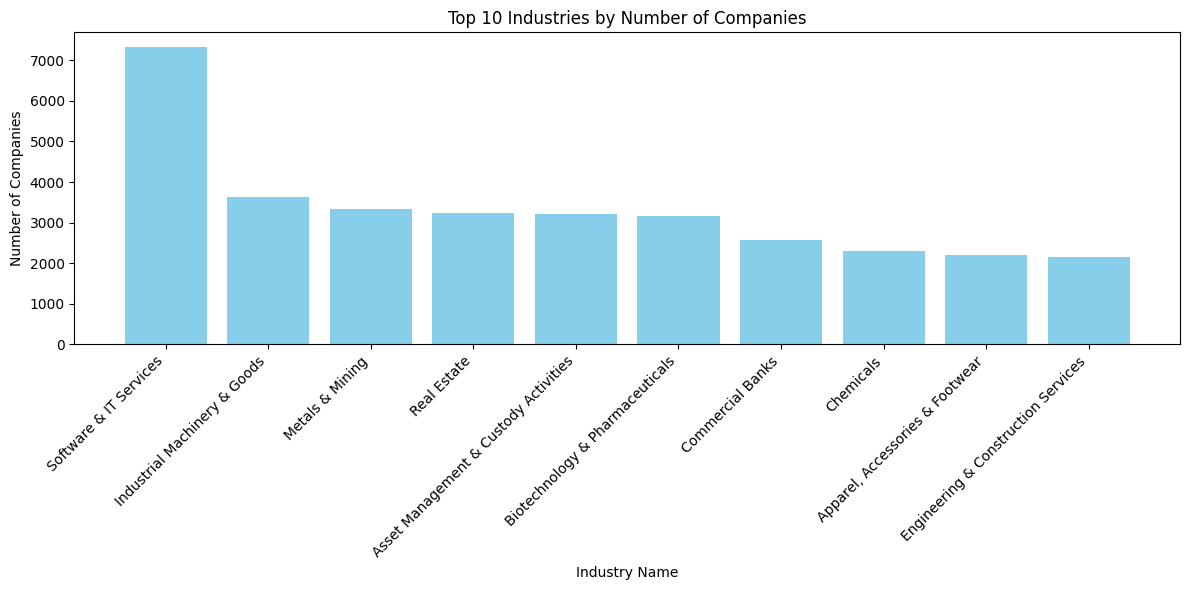

In [114]:
# take top 10 industries
top_10_industries = industry_companies_counts.sort_values(by='count', ascending=False).head(10)
top_10_industries
# Plot
plt.figure(figsize=(12, 6))
plt.bar(top_10_industries['industry_name'], top_10_industries['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Industry Name')
plt.ylabel('Number of Companies')
plt.title('Top 10 Industries by Number of Companies')
plt.tight_layout()
plt.show()

## Data Summary - Metric name, Metric value, Metric unit

there are 104 metrics but the user guide says it has 105 metrics, we should use this notebook at reference

In [119]:
metrics_column = df[['metric_name', 'metric_unit', 'data_type']].drop_duplicates()

metrics_column

,metric_name,metric_unit,data_type
0,GRIEVANCE_REPORTING_PROCESS,Yes/No,int
1,IMPROVEMENT_TOOLS_BUSINESS_ETHICS,Yes/No,int
2,AIRPOLLUTANTS_INDIRECT,USD (000),float
4,BOARDMEETINGATTENDANCEAVG,%,float
5,WATERWITHDRAWALTOTAL,Cubic meters,float
...,...,...,...
14153,COMMMEETINGSATTENDANCEAVG,%,float
19147,ANNUAL_MEDIAN_COMPENSATION,USD,float
115882,ELECTRICITYPURCHASED,GJ,float
511474,ENERGYPURCHASEDDIRECT,GJ,float


In [123]:
number_of_metric = metrics_column['metric_unit'].nunique()
number_of_metric

22

In [125]:
metrics_units = metrics_column.groupby(['metric_unit', 'data_type'])['metric_name'].nunique()
metrics_units

metric_unit                                                  data_type
%                                                            float        18
% growth in number of employees over last year               float         1
Cubic meters                                                 float         1
Cubic meters / million EUR of revenue of investee companies  float         1
GJ                                                           float         6
Hours/employee                                               float         1
Injured / million hours                                      float         1
Non / audit USD / audit USD                                  float         1
Number of breaches                                           int           1
Number of days                                               float         1
Number of fatalities                                         float         1
Ratio                                                        float         1
Tons 

<Figure size 600x600 with 0 Axes>

([<matplotlib.patches.Wedge at 0x126a275d0>,
 [Text(-0.6812933104349228, -0.8636199541213856, 'Categorical'),
  Text(0.6812933912928555, 0.8636198903340985, 'Numerical')],
 [Text(-0.3716145329645033, -0.4710654295207557, '53'),
  Text(0.3716145770688302, 0.47106539472769005, '51')])

Text(0.5, 1.0, 'Distribution of Metric Units: Categorical vs Numerical')

(-1.0999995302585537,
 1.0999950216873833,
 -1.0999995073680364,
 1.099997365527374)

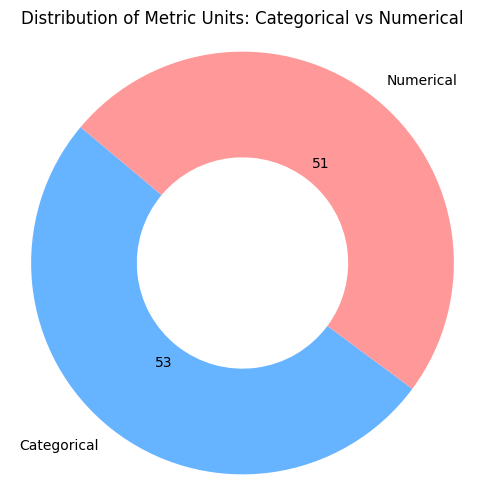

In [127]:
# Data for the pie chart
labels = ['Categorical', 'Numerical']
sizes = [53, 51]
colors = ['#66b3ff', '#ff9999']
def absolute_value(val):
    total = sum(sizes)
    count = int(round(val * total / 100))
    return f'{count}'
    
# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=absolute_value,
    startangle=140,
    wedgeprops=dict(width=0.5)
)
plt.title('Distribution of Metric Units: Categorical vs Numerical')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.show()

<Figure size 1200x1000 with 0 Axes>

<BarContainer object of 22 artists>

Text(0.5, 0, 'Count of Metric Names')

Text(0, 0.5, 'Metric Unit | Data Type')

Text(0.5, 1.0, 'Counts of Metric Names by Metric Unit and Data Type')

Text(1.5, 0, '1')

Text(1.5, 1, '1')

Text(1.5, 2, '1')

Text(1.5, 3, '1')

Text(1.5, 4, '1')

Text(1.5, 5, '1')

Text(1.5, 6, '1')

Text(1.5, 7, '1')

Text(1.5, 8, '1')

Text(1.5, 9, '1')

Text(1.5, 10, '1')

Text(1.5, 11, '1')

Text(1.5, 12, '1')

Text(1.5, 13, '1')

Text(1.5, 14, '1')

Text(2.5, 15, '2')

Text(3.5, 16, '3')

Text(3.5, 17, '3')

Text(4.5, 18, '4')

Text(6.5, 19, '6')

Text(18.5, 20, '18')

Text(53.5, 21, '53')

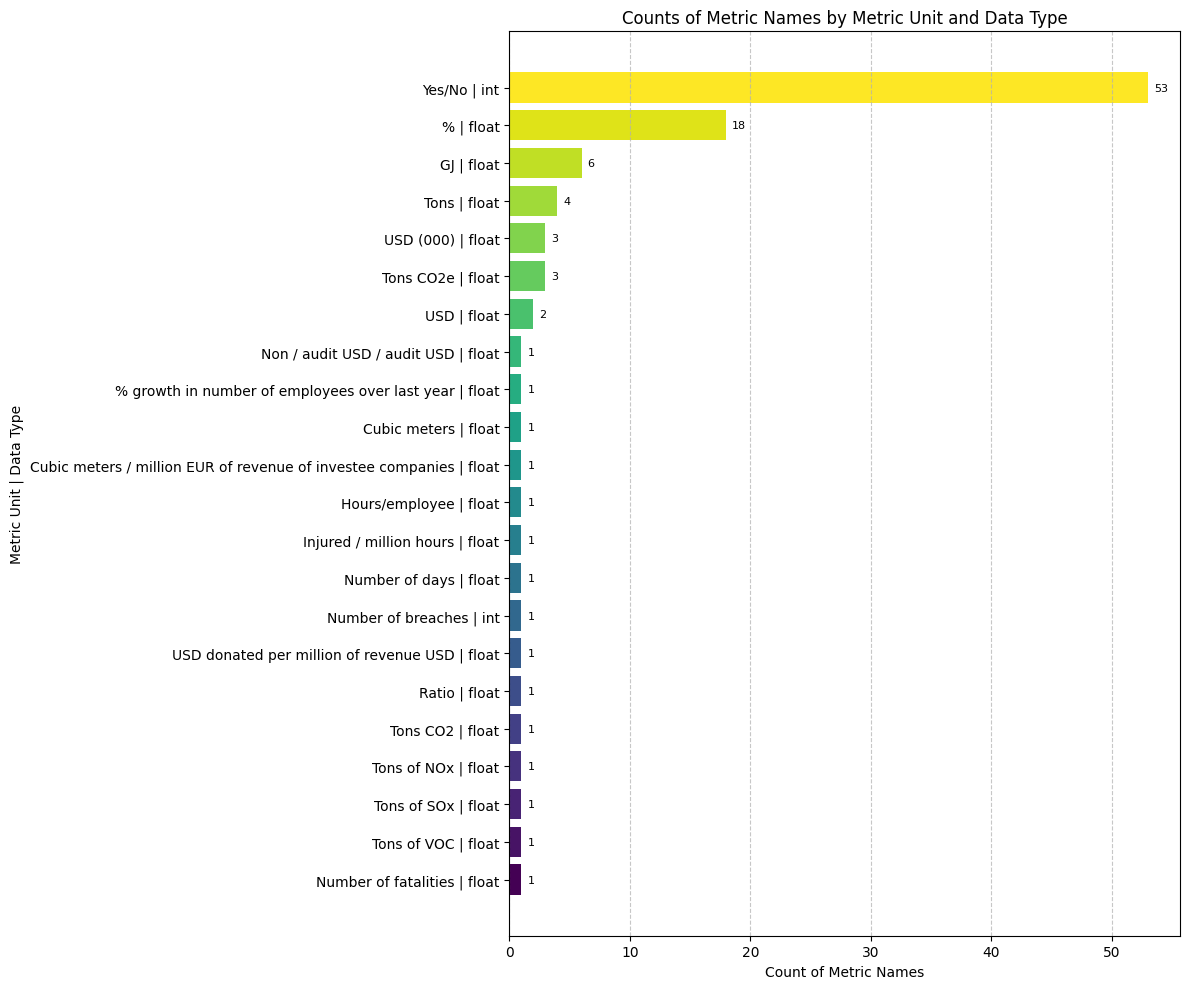

In [134]:
# Group
metrics_units = metrics_column.groupby(['metric_unit', 'data_type'])['metric_name'].nunique()

# Sort
metrics_units_sorted = metrics_units.sort_values(ascending=True)

# Flatten MultiIndex into readable strings
metrics_units_labels = [' | '.join(map(str, idx)) for idx in metrics_units_sorted.index]

# Colors
colors = plt.cm.viridis(np.linspace(0, 1, len(metrics_units_sorted)))

# Plot
plt.figure(figsize=(12, 10))
plt.barh(metrics_units_labels, metrics_units_sorted.values, color=colors)

# Labels and title
plt.xlabel('Count of Metric Names')
plt.ylabel('Metric Unit | Data Type')
plt.title('Counts of Metric Names by Metric Unit and Data Type')

# Add text on bars
for index, value in enumerate(metrics_units_sorted.values):
    plt.text(value + 0.5, index, str(value), va='center', ha='left', fontsize=8)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Below is the example for checking result in value returned in dashboard

## Semiconductor:

In [11]:
semiconductors_companies = df[df['industry_name'] == 'Semiconductors']
semiconductors_companies['perm_id'].value_counts()

perm_id
4295868108    429
4295867372    390
4295916023    388
4295891102    388
4295891506    388
             ... 
5080056680      1
4296125332      1
4295906265      1
5055670914      1
4296497237      1
Name: count, Length: 859, dtype: int64

In [14]:
semiconductor = df[(df['perm_id'] == 4295868108) & (df['metric_year'] == '2019-12-31')]
semiconductor

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name
4031871,Soitec SA,4295868108,float,REPORTED,Total waste that is generated by the company a...,WASTE_RECYCLED,Tons,4960.09,2019-12-31,441,NaN,Clarity AI,2019-12-31 00:00:00,E,France,Semiconductors
4031875,Soitec SA,4295868108,int,CALCULATED,Does the company report on its impact on biodi...,BIODIVERSITY_IMPACT_REDUCTION,Yes/No,0.00,2019-12-31,441,NaN,Clarity AI,2019-09-27 14:29:37,E,France,Semiconductors
4031876,Soitec SA,4295868108,float,CALCULATED,Employment growth over the last year.,ANALYTICEMPLOYMENTCREATION,% growth in number of employees over last year,36.48,2019-12-31,441,NaN,Clarity AI,2019-12-31 00:00:00,G,France,Semiconductors
4031883,Soitec SA,4295868108,float,REPORTED,Total amount of hazardous waste produced in tons.,HAZARDOUSWASTE,Tons,4469.00,2019-12-31,441,NaN,Clarity AI,2019-12-31 00:00:00,E,France,Semiconductors
4031886,Soitec SA,4295868108,float,REPORTED,Rate of total number of injuries (Total Injury...,TIRTOTAL,Injured / million hours,5.30,2019-12-31,441,NaN,Clarity AI,2019-12-31 00:00:00,S,France,Semiconductors
4031887,Soitec SA,4295868108,float,ESTIMATED,Total amount of SOx emissions emitted in tons.,SOXEMISSIONS,Tons of SOx,0.48,2019-12-31,441,NaN,Clarity AI,NaN,E,France,Semiconductors
4031889,Soitec SA,4295868108,int,CALCULATED,Has the company set targets or objectives to b...,TARGETS_WATER_EFFICIENCY,Yes/No,0.00,2019-12-31,441,NaN,Clarity AI,2019-12-31 00:00:00,E,France,Semiconductors
4031895,Soitec SA,4295868108,int,CALCULATED,Does the company have a provision or comply wi...,WHISTLEBLOWER_PROTECTION,Yes/No,0.00,2019-12-31,441,NaN,Clarity AI,2019-12-31 00:00:00,S,France,Semiconductors
4031897,Soitec SA,4295868108,int,CALCULATED,Has the company limited the rights of sharehol...,CALL_MEETINGS_LIMITED_RIGHTS,Yes/No,0.00,2019-12-31,441,NaN,Clarity AI,2019-12-31 00:00:00,G,France,Semiconductors
4031910,Soitec SA,4295868108,int,CALCULATED,Has the company established a program or an in...,ANIMAL_TESTING_REDUCTION,Yes/No,0.00,2019-12-31,441,NaN,Clarity AI,2019-12-31 00:00:00,S,France,Semiconductors


## Biotechnology & pharmaceuticals:

In [15]:
bio_companies = df[df['industry_name'] == 'Biotechnology & Pharmaceuticals']
bio_companies['perm_id'].value_counts()

perm_id
4295888632    421
4295872868    420
4295875158    391
4295904341    391
4295863746    389
             ... 
4297165456      1
5051399101      1
5044507075      1
4296049888      1
4296803561      1
Name: count, Length: 3165, dtype: int64

In [142]:
bio = df[(df['perm_id'] == 4295888632) & (df['metric_year'] == '2019-12-31')]
bio

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name
4037724,Aspen Pharmacare Holdings Ltd,4295888632,int,REPORTED,Does the company report or show to use human r...,HUMAN_RIGHTS_CONTRACTOR,Yes/No,1.00,2019-12-31,434,NaN,Clarity AI,2019-12-31 00:00:00,S,South Africa,Biotechnology & Pharmaceuticals
4037749,Aspen Pharmacare Holdings Ltd,4295888632,float,REPORTED,Scope 2 emissions that result from the generat...,CO2INDIRECTSCOPE2,Tons CO2e,158899.00,2019-12-31,434,NaN,Clarity AI,2019-12-31 00:00:00,E,South Africa,Biotechnology & Pharmaceuticals
4037751,Aspen Pharmacare Holdings Ltd,4295888632,float,ESTIMATED,Total amount of SOx emissions emitted in tons.,SOXEMISSIONS,Tons of SOx,44.71,2019-12-31,434,NaN,Clarity AI,NaN,E,South Africa,Biotechnology & Pharmaceuticals
4037752,Aspen Pharmacare Holdings Ltd,4295888632,float,ESTIMATED,Amount of Volatile Organic Compounds (VOC) emi...,VOCEMISSIONS,Tons of VOC,25.77,2019-12-31,434,NaN,Clarity AI,NaN,E,South Africa,Biotechnology & Pharmaceuticals
4037759,Aspen Pharmacare Holdings Ltd,4295888632,int,REPORTED,Has the company established a program or an in...,ANIMAL_TESTING_REDUCTION,Yes/No,0.00,2019-12-31,434,NaN,Clarity AI,2019-12-31 00:00:00,S,South Africa,Biotechnology & Pharmaceuticals
4037775,Aspen Pharmacare Holdings Ltd,4295888632,int,REPORTED,Has the company set targets or objectives to b...,TARGETS_WATER_EFFICIENCY,Yes/No,0.00,2019-12-31,434,NaN,Clarity AI,2019-12-31 00:00:00,E,South Africa,Biotechnology & Pharmaceuticals
4037784,Aspen Pharmacare Holdings Ltd,4295888632,float,REPORTED,Percentage of employee turnover.,TURNOVEREMPLOYEES,%,14.30,2019-12-31,434,NaN,Clarity AI,2019-12-31 00:00:00,S,South Africa,Biotechnology & Pharmaceuticals
4037798,Aspen Pharmacare Holdings Ltd,4295888632,float,REPORTED,Percentage of non-executive board members on t...,COMPCOMMNONEXECMEMBERS,%,100.00,2019-12-31,434,NaN,Clarity AI,2019-12-31 00:00:00,G,South Africa,Biotechnology & Pharmaceuticals
4037826,Aspen Pharmacare Holdings Ltd,4295888632,float,REPORTED,Percentage of independent board members as rep...,ANALYTICINDEPBOARD,%,60.00,2019-12-31,434,NaN,Clarity AI,2019-12-31 00:00:00,G,South Africa,Biotechnology & Pharmaceuticals
4037829,Aspen Pharmacare Holdings Ltd,4295888632,float,REPORTED,Total water withdrawal in cubic meters.,WATERWITHDRAWALTOTAL,Cubic meters,1693000.00,2019-12-31,434,NaN,Clarity AI,2019-12-31 00:00:00,E,South Africa,Biotechnology & Pharmaceuticals


## Metal & mining:

In [148]:
metal_companies = df[df['industry_name'] == 'Metals & Mining']
metal_companies['perm_id'].value_counts()

perm_id
4295890178    424
4295873625    422
4295872982    420
4295908588    406
4295861443    406
             ... 
4295896687      1
5000275709      1
5079226870      1
5074524767      1
5035572455      1
Name: count, Length: 3344, dtype: int64

In [152]:
metal = df[(df['perm_id'] == 4295872982) & (df['metric_year'] == '2022-12-31') & (df['pillar'] == 'E')]
metal

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name
4048293,Vedanta Ltd,4295872982,float,REPORTED,Total amount of waste produced in tons.,WASTETOTAL,Tons,1.952780e+07,2022-12-31,424,NaN,Clarity AI,2022-12-31 00:00:00,E,India,Metals & Mining
4048307,Vedanta Ltd,4295872982,float,REPORTED,Scope 3 emissions that occur in the value chai...,CO2INDIRECTSCOPE3,Tons CO2e,3.741000e+07,2022-12-31,424,NaN,Clarity AI,2022-12-31 00:00:00,E,India,Metals & Mining
4048567,Vedanta Ltd,4295872982,float,REPORTED,Total water withdrawal in cubic meters.,WATERWITHDRAWALTOTAL,Cubic meters,2.204332e+08,2022-12-31,424,NaN,Clarity AI,2022-12-31 00:00:00,E,India,Metals & Mining
4048636,Vedanta Ltd,4295872982,int,REPORTED,Does the company develop products and services...,SUSTAINABLE_BUILDING_PRODUCTS,Yes/No,0.000000e+00,2022-12-31,424,NaN,Clarity AI,2022-12-31 00:00:00,E,India,Metals & Mining
4048674,Vedanta Ltd,4295872982,float,REPORTED,Total renewable energy consumed in Gigajoules.,RENEWENERGYCONSUMED,GJ,1.462302e+07,2022-12-31,424,NaN,Clarity AI,2022-12-31 00:00:00,E,India,Metals & Mining
4048760,Vedanta Ltd,4295872982,float,REPORTED,Total amount of SOx emissions emitted in tons.,SOXEMISSIONS,Tons of SOx,2.747900e+05,2022-12-31,424,NaN,Clarity AI,2022-12-31 00:00:00,E,India,Metals & Mining
4048827,Vedanta Ltd,4295872982,float,ESTIMATED,Amount of Volatile Organic Compounds (VOC) emi...,VOCEMISSIONS,Tons of VOC,6.523000e+02,2022-12-31,424,NaN,Clarity AI,NaN,E,India,Metals & Mining
4048855,Vedanta Ltd,4295872982,float,REPORTED,Scope 1 emissions that occur within a company’...,CO2DIRECTSCOPE1,Tons CO2e,5.948675e+07,2022-12-31,424,NaN,Clarity AI,2022-12-31 00:00:00,E,India,Metals & Mining
4049073,Vedanta Ltd,4295872982,float,REPORTED,Total energy consumed by a company within its ...,ENERGYUSETOTAL,GJ,5.639758e+08,2022-12-31,424,NaN,Clarity AI,2022-12-31 00:00:00,E,India,Metals & Mining
4049195,Vedanta Ltd,4295872982,int,REPORTED,Does the company report or show initiatives to...,ORGANIC_PRODUCTS_INITIATIVES,Yes/No,0.000000e+00,2022-12-31,424,NaN,Clarity AI,2022-12-31 00:00:00,E,India,Metals & Mining


## Chemicals:

In [157]:
chemical_companies = df[df['industry_name'] == 'Chemicals']
chemical_companies['perm_id'].value_counts()

perm_id
4295887317    418
4295892119    418
4295887339    415
5036162966    412
4295887277    412
             ... 
4295898155      1
5078367128      1
5044025733      1
4295899785      1
5000064950      1
Name: count, Length: 2301, dtype: int64

In [161]:
chemical = df[(df['perm_id'] == 4295892119) & (df['metric_year'] == '2018-12-31') & (df['pillar'] == 'E')]
chemical

,company_name,perm_id,data_type,disclosure,metric_description,metric_name,metric_unit,metric_value,metric_year,nb_points_of_observations,metric_period,provider_name,reported_date,pillar,headquarter_country,industry_name
4034772,Far Eastern New Century Corp,4295892119,float,ESTIMATED,External cost of pollutants released to air by...,AIRPOLLUTANTS_DIRECT,USD (000),8081.68,2018-12-31,437,NaN,Clarity AI,NaN,E,"Taiwan, China",Chemicals
4034822,Far Eastern New Century Corp,4295892119,float,REPORTED,Total amount of NOx emissions emitted in tons.,NOXEMISSIONS,Tons of NOx,854.00,2018-12-31,437,NaN,Clarity AI,2018-12-31 00:00:00,E,"Taiwan, China",Chemicals
4034889,Far Eastern New Century Corp,4295892119,float,REPORTED,Total amount of SOx emissions emitted in tons.,SOXEMISSIONS,Tons of SOx,220.00,2018-12-31,437,NaN,Clarity AI,2018-12-31 00:00:00,E,"Taiwan, China",Chemicals
4034912,Far Eastern New Century Corp,4295892119,int,REPORTED,Is the company aware that climate change can r...,CLIMATE_CHANGE_RISKS_OPP,Yes/No,1.00,2018-12-31,437,NaN,Clarity AI,2018-12-31 00:00:00,E,"Taiwan, China",Chemicals
4035072,Far Eastern New Century Corp,4295892119,float,REPORTED,Total amount of waste produced in tons.,WASTETOTAL,Tons,105000.00,2018-12-31,437,NaN,Clarity AI,2018-12-31 00:00:00,E,"Taiwan, China",Chemicals
4035129,Far Eastern New Century Corp,4295892119,int,REPORTED,Does the company report on its impact on biodi...,BIODIVERSITY_IMPACT_REDUCTION,Yes/No,1.00,2018-12-31,437,NaN,Clarity AI,2018-12-31 00:00:00,E,"Taiwan, China",Chemicals
4035152,Far Eastern New Century Corp,4295892119,float,REPORTED,Amount of Volatile Organic Compounds (VOC) emi...,VOCEMISSIONS,Tons of VOC,465.00,2018-12-31,437,NaN,Clarity AI,2018-12-31 00:00:00,E,"Taiwan, China",Chemicals
4035312,Far Eastern New Century Corp,4295892119,float,REPORTED,Total amount of hazardous waste produced in tons.,HAZARDOUSWASTE,Tons,5038.00,2018-12-31,437,NaN,Clarity AI,2018-12-31 00:00:00,E,"Taiwan, China",Chemicals
4035407,Far Eastern New Century Corp,4295892119,float,REPORTED,Total water withdrawal in cubic meters.,WATERWITHDRAWALTOTAL,Cubic meters,19347000.00,2018-12-31,437,NaN,Clarity AI,2018-12-31 00:00:00,E,"Taiwan, China",Chemicals
4035461,Far Eastern New Century Corp,4295892119,float,REPORTED,Amount of particulate matter (a complex mixtur...,PARTICULATE_MATTER_EMISSIONS,Tons,68.00,2018-12-31,437,NaN,Clarity AI,2018-12-31 00:00:00,E,"Taiwan, China",Chemicals
